In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

physical_device = tf.config.experimental.list_physical_devices("GPU")
print(physical_device)

# 限制显存使用
tf.config.experimental.set_memory_growth(physical_device[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# load data set, need mnist.npz in current work folder
with np.load("resources/mnist.npz", allow_pickle=True) as f:
    x_train, y_train = f["x_train"], f["y_train"]
    x_test, y_test = f["x_test"], f["y_test"]

print(x_train.shape, x_test.shape)

# 数据重塑至四维 b w h c
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# 数据归一化
x_train = tf.cast(x_train, tf.float32) / 255
x_test = tf.cast(x_test, tf.float32) / 255

(60000, 28, 28) (10000, 28, 28)


2023-11-12 11:29:52.050841: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-11-12 11:29:52.050867: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-12 11:29:52.050876: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-12 11:29:52.051088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-12 11:29:52.051473: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


/var/folders/ly/1nz92nfj1jq23yd3gk5cxch00000gn/T/ipykernel_19695/934645834.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i].fill(rd)


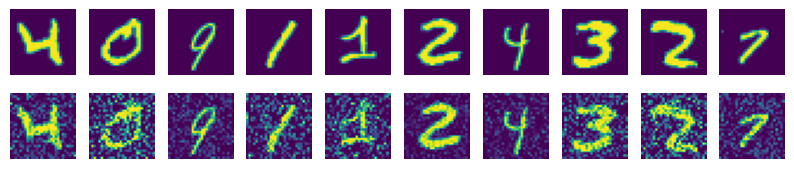

In [4]:
def range_rand(size, min=0.0, max=1.0):
    return (max - min) * np.random.random(size=size) + min

def gen_weight(shape, min, max):
    weights = np.empty(shape)
    for i in range(0, shape[0]):
        rd = range_rand(1, min, max)
        weights[i].fill(rd)
    return weights

def data_set_reparam(min,max):
    
    global x_train_noised, x_test_noised
    global x_train_numpy, x_test_numpy

    x_train_noised = x_train + gen_weight(x_train.shape, min, max) * np.random.normal(
        0, 1, size=x_train.shape
    )
    x_test_noised = x_test + gen_weight(x_test.shape, min, max) * np.random.normal(
        0, 1, size=x_test.shape
    )

    x_train_noised = np.clip(x_train_noised, 0.0, 1.0)
    x_test_noised = np.clip(x_test_noised, 0.0, 1.0)

    import matplotlib.pyplot as plt

    step = 20
    x_train_numpy = x_train.numpy()
    x_test_numpy = x_test.numpy()
    plt.figure(figsize=(10, 2))
    for i in range(0 + step, 10 + step):
        plt.subplot(2, 10, i - step + 1)
        plt.axis("off")
        plt.imshow(x_train_numpy[i].reshape(28, 28))
        plt.subplot(2, 10, i - step + 11)
        plt.axis("off")
        plt.imshow(x_train_noised[i].reshape(28, 28))

    x_train_noised = tf.cast(x_train_noised, tf.float32) / 255
    x_test_noised = tf.cast(x_test_noised, tf.float32) / 255

data_set_reparam(0.1,0.5)

In [5]:
# Encode 卷积
input_layer = tf.keras.layers.Input(x_train.shape[1:])
hidden_layer = tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same")(
    input_layer
)
hidden_layer = tf.keras.layers.MaxPooling2D(2, padding="same")(hidden_layer)
hidden_layer = tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same")(
    hidden_layer
)
hidden_layer = tf.keras.layers.MaxPooling2D(2, padding="same")(hidden_layer)

# Decode 反卷积
hidden_layer = tf.keras.layers.Conv2DTranspose(
    16, 3, strides=2, activation="relu", padding="same"
)(hidden_layer)
output_layer = tf.keras.layers.Conv2DTranspose(
    1, 3, strides=2, activation="relu", padding="same"
)(hidden_layer)

model_trained = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_trained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 16)        4624  

In [12]:
model_trained.compile(optimizer=tf.keras.optimizers.legacy.Adam(0.001),loss='mse')

/var/folders/ly/1nz92nfj1jq23yd3gk5cxch00000gn/T/ipykernel_19695/934645834.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i].fill(rd)


Epoch 1/40
118/118 [==============================] - 3s 20ms/step - loss: 0.0911 - val_loss: 0.0776
Epoch 2/40
118/118 [==============================] - 2s 18ms/step - loss: 0.0662 - val_loss: 0.0479
Epoch 3/40
118/118 [==============================] - 2s 18ms/step - loss: 0.0399 - val_loss: 0.0365
Epoch 4/40
118/118 [==============================] - 2s 18ms/step - loss: 0.0340 - val_loss: 0.0317
Epoch 5/40
118/118 [==============================] - 2s 18ms/step - loss: 0.0303 - val_loss: 0.0283
Epoch 6/40
118/118 [==============================] - 2s 18ms/step - loss: 0.0270 - val_loss: 0.0252
Epoch 7/40
118/118 [==============================] - 2s 17ms/step - loss: 0.0242 - val_loss: 0.0227
Epoch 8/40
118/118 [==============================] - 2s 17ms/step - loss: 0.0220 - val_loss: 0.0207
Epoch 9/40
118/118 [==============================] - 2s 17ms/step - loss: 0.0203 - val_loss: 0.0192
Epoch 10/40
118/118 [==============================] - 2s 17ms/step - loss: 0.0189 - val_lo

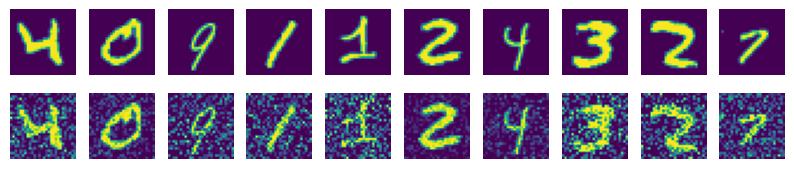

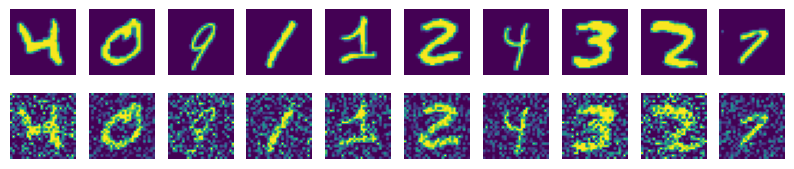

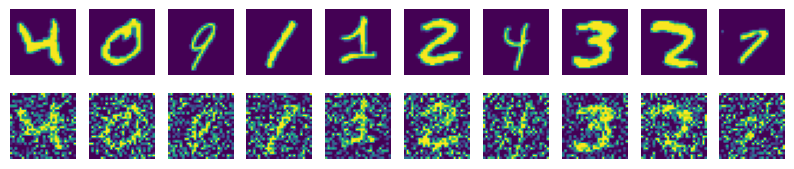

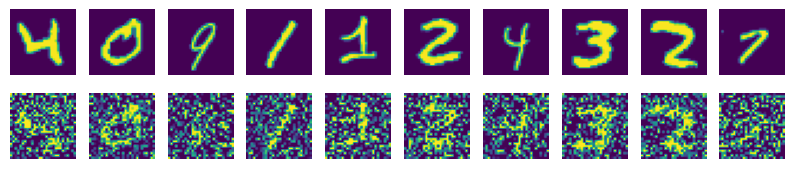

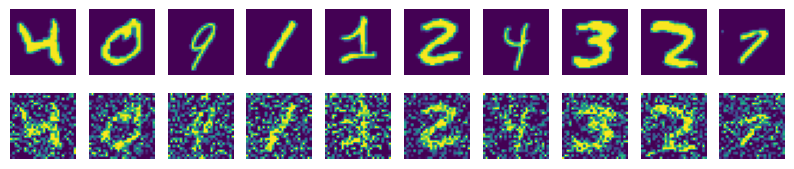

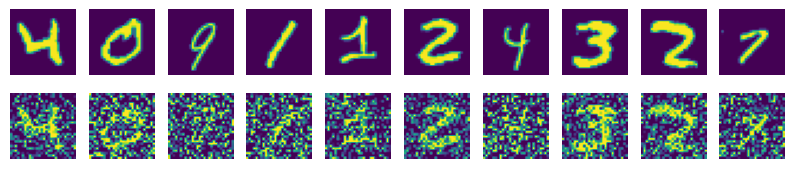

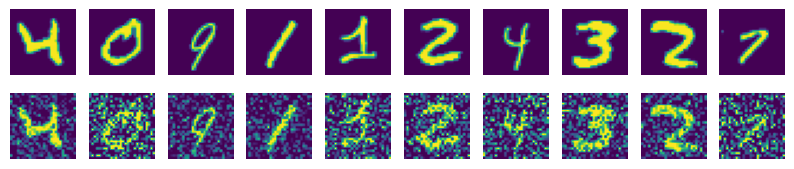

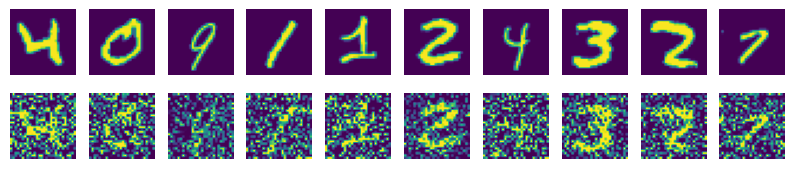

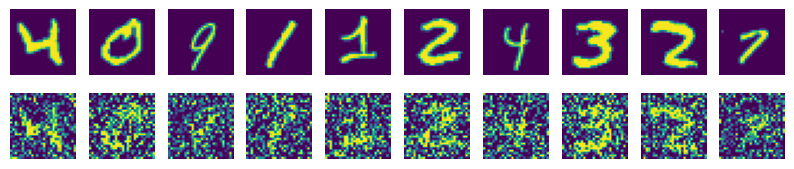

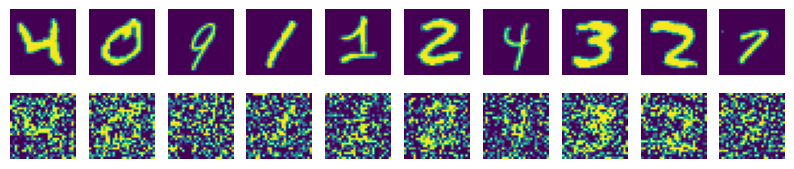

In [13]:
def train_model(epochs, batch_size):
    model_trained.fit(
        x_train_noised,
        x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(x_test_noised, x_test),
    )


data_set_reparam(0.1, 0.5)
train_model(40, 512)

data_set_reparam(0.3, 0.6)
train_model(50, 256)

data_set_reparam(0.4, 0.7)
train_model(10, 128)

data_set_reparam(0.5, 0.9)
train_model(10, 64)

data_set_reparam(0.4, 0.7)
train_model(10, 128)

data_set_reparam(0.5, 0.9)
train_model(10, 64)

data_set_reparam(0.3, 0.7)
train_model(15, 64)

data_set_reparam(0.5, 0.9)
train_model(15, 32)

data_set_reparam(0.6, 0.92)
train_model(20, 32)

data_set_reparam(0.8, 0.93)
train_model(20, 32)

/var/folders/ly/1nz92nfj1jq23yd3gk5cxch00000gn/T/ipykernel_19695/934645834.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights[i].fill(rd)


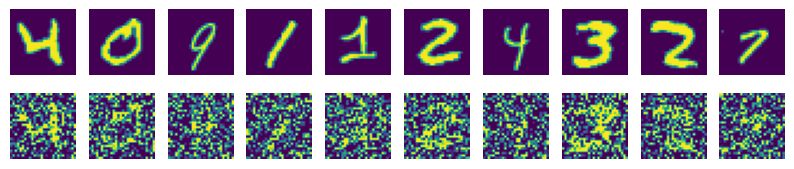

In [6]:
data_set_reparam(0.9, 0.9)

In [24]:
# tf.keras.models.save_model(model_trained, "resources/cnn_denoise.h5")
model_trained = tf.keras.models.load_model("resources/cnn_denoise.h5")
test_set_predict = model_trained.predict(x_test_noised)

/var/folders/ly/1nz92nfj1jq23yd3gk5cxch00000gn/T/ipykernel_19695/3377435499.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model_trained, "resources/cnn_denoise.h5")


313/313 [==============================] - 1s 2ms/step


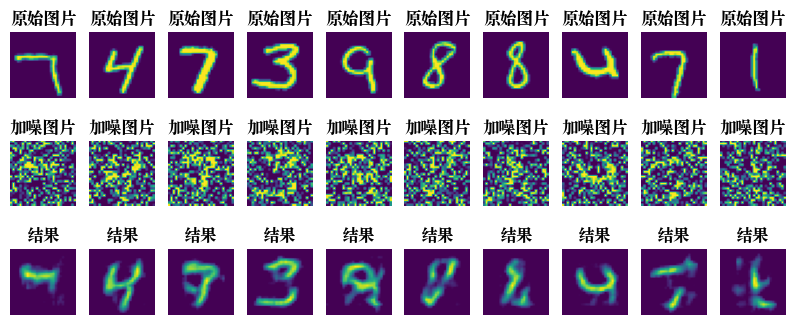

In [25]:
# Show result of test set
plt.figure(figsize=(10, 4))
plt.rcParams['font.sans-serif'] = ['Songti SC']

step = 909
x_test_noised_numpy = x_test_noised.numpy()

for i in range(0 + step, 10 + step):
    plt.subplot(3, 10, i - step + 1)
    plt.axis("off")
    plt.title('原始图片')
    plt.imshow(x_test_numpy[i])
    plt.subplot(3, 10, i - step + 11)
    plt.axis("off")
    plt.title('加噪图片')
    plt.imshow(x_test_noised[i])
    plt.subplot(3, 10, i - step + 21)
    plt.axis("off")
    plt.title('结果')
    plt.imshow(test_set_predict[i])